In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import nltk
import re
from nltk.corpus import stopwords#, PlainTextCorpusReader
from nltk import word_tokenize, ngrams
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
from transformers import LlamaTokenizer
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

In [37]:
!pip install sentence_transformers

     -------------------------------------- 163.3/163.3 kB 4.8 MB/s eta 0:00:00


In [76]:
raw_data=pd.read_csv('text.csv')

In [83]:
class_to_emotion = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
raw_data['emotion'] = raw_data['label'].map(class_to_emotion)

category_counts = raw_data['emotion'].value_counts()

In [84]:
raw_data

,Unnamed: 0,text,label,emotion
0,0,i just feel really helpless and heavy hearted,4,fear
1,1,ive enjoyed being able to slouch about relax a...,0,sadness
2,2,i gave up my internship with the dmrg and am f...,4,fear
3,3,i dont know i feel so lost,0,sadness
4,4,i am a kindergarten teacher and i am thoroughl...,4,fear
...,...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2,love
416805,416805,i began to realize that when i was feeling agi...,3,anger
416806,416806,i feel very curious be why previous early dawn...,5,surprise
416807,416807,i feel that becuase of the tyranical nature of...,3,anger


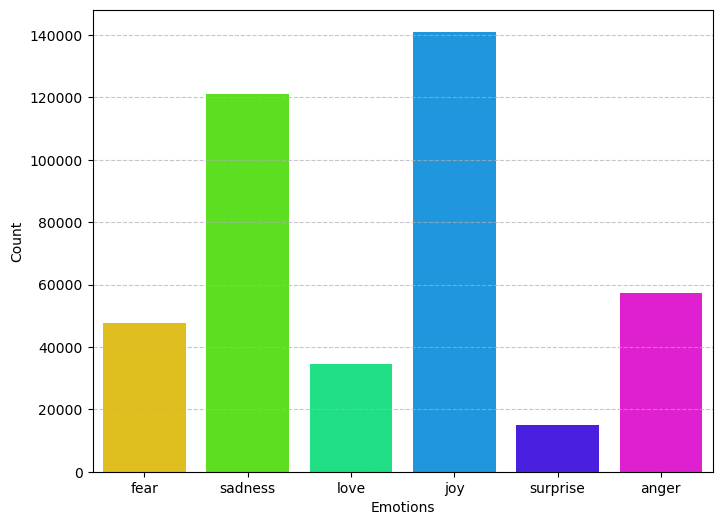

In [88]:
plt.figure(figsize=(8, 6))
#category_counts.plot(kind='bar')#, color='skyblue')  # Create the bar plot
plt.title('Bar Plot of emotion counts')
sns.countplot(data=raw_data, x='emotion', palette='hsv') 
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
raw_data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [12]:
raw_data.shape

(416809, 3)

In [93]:
data=raw_data[['text', 'label']]

In [95]:
data.groupby('label').count()

,text
label,
0,121187
1,141067
2,34554
3,57317
4,47712
5,14972


In [16]:
data['text'] = data['text'].astype(str)
data['text'] = data['text'].str.lower()
data['text'] = data['text'].str.replace('[^\w\s]','')

In [24]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...


True

In [25]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
nrows=len(data)

lematized_text_list=[]
for row in range (0,nrows):
    lemmatized_list = []
    text = data.loc[row]['text']
    text_words = text.split(" ")
    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lematized_text_list.append(lemmatized_text)
    
data['text'] = lematized_text_list

In [29]:
stop_words=list(stopwords.words('english'))
for stop_word in stop_words:
    regex_stopword=r"\b" + stop_word +r"\b"
    data['WO_st_words'] = data['text'].str.replace(regex_stopword, '')

# Data Embedding

In [53]:
data.head()

,text,label,WO_st_words
0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted
1,ive enjoy be able to slouch about relax and un...,0,ive enjoy be able to slouch about relax and un...
2,i give up my internship with the dmrg and be f...,4,i give up my internship with the dmrg and be f...
3,i dont know i feel so lose,0,i dont know i feel so lose
4,i be a kindergarten teacher and i be thoroughl...,4,i be a kindergarten teacher and i be thoroughl...


In [55]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

cpu


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [43]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')#'sentence-transformers/all_mpnet_base_v2')
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [56]:
max_i=data.shape[0]
print(max_i)
batch_size=50000
num_batches=int(max_i/batch_size)
iloc_indexes=[x*batch_size for x in range(num_batches+1)]

416809


In [57]:
print(num_batches)

8


In [59]:
encoded_text_df_list=[]
n=len(data)
for i in iloc_indexes:
    if i+batch_size>max_i:
        end_i=max_i
    else:
        end_i=i+batch_size
    text=data.iloc[i:end_i]['WO_st_words'].values
    embeddings=model.encode(text)
    embedded_df=pd.DataFrame(embeddings)
    embedded_df.columns=['c_' + str(col) for col in embedded_df.columns]
    embedded_df['text'] = text
    #embedded_df['index']=i
    embedded_df['label']=data.iloc[i:end_i]['label'].values
    encoded_text_df_list.append(embedded_df)
    r=1200000-(n%1000000)
    if ((i!=0) and (i%1000000==0)) or (i+batch_size>max_i):
        pd.concat(encoded_text_df_list, ignore_index=True).to_csv('embeddings/mpnet_embed_df.csv', index=False)
        #pd.concat(encoded_text_df_list, ignore_index=True).to_parquet('embeddings/mpnet_embed_pq.gzip', compression='gzip')
        print('the first part of data is done and saved')
       

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

## Data Partitioning

In [61]:
embd_data=pd.read_csv('embeddings/mpnet_embed_df.csv')

In [67]:
X = embd_data.drop('label', axis=1)
y = embd_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [97]:
train

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_760,c_761,c_762,c_763,c_764,c_765,c_766,c_767,text,label
296621,0.057727,0.027517,-0.030437,-0.061579,-0.006576,-0.063459,-0.049406,0.021162,-0.005058,-0.074257,...,0.028914,-0.013897,-0.003551,-0.038635,0.031419,-0.013297,0.002431,0.021442,recent breakup of seriors longterm relationship,0
289890,-0.042763,-0.022068,-0.015751,0.028329,-0.074662,0.047185,-0.029067,-0.069941,-0.006860,-0.017851,...,-0.034707,0.008046,-0.006219,-0.029384,-0.033398,-0.012191,0.019368,0.012939,i feel truly bless that they ask me to do it f...,1
95555,0.053061,-0.040572,0.009053,-0.020620,-0.054520,0.024682,0.027064,-0.031622,0.006368,-0.045796,...,0.065279,0.020666,0.012254,0.005655,0.013814,0.024061,-0.017169,0.027947,i wake up it be dark and he start to make me f...,0
217086,-0.021273,0.053084,0.008725,0.000652,0.057878,0.007836,-0.056173,-0.015094,0.024574,0.022435,...,-0.039931,0.004527,0.034232,-0.000168,-0.013256,0.042876,0.013006,0.009684,i do know for a fact that gut feel be real lik...,3
196567,-0.050520,0.092292,0.025079,-0.015721,0.016530,0.037277,-0.063429,-0.001500,0.010056,-0.022299,...,-0.028914,0.001015,0.018443,-0.034361,-0.006708,0.034340,-0.050754,0.008599,im still feel smug about beat that girl who li...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385744,-0.000470,0.061990,0.013851,-0.047472,0.025206,-0.017095,-0.044975,0.021902,-0.016591,-0.013718,...,0.050612,-0.002638,0.002195,-0.046143,0.020856,-0.027365,-0.058251,0.016495,i still look awful im feel pretty lovely,2
247874,0.002896,0.007195,0.017231,-0.004442,0.054806,0.007068,-0.099124,-0.018312,0.108147,0.021809,...,-0.048933,0.044318,-0.037707,0.000990,-0.055314,0.048026,0.010615,-0.029663,i realise that i didn t feel any pain and i be...,1
343149,-0.009608,0.038026,-0.035670,-0.016797,-0.007337,-0.002520,-0.031446,0.023492,-0.021056,0.000799,...,-0.012194,0.028281,-0.002007,-0.000250,-0.005889,-0.004514,0.037860,-0.026773,i feel like i m look at a strange plant life d...,5
331147,0.027947,0.037844,0.043803,-0.027001,0.035751,0.041561,-0.106433,-0.016536,-0.003890,-0.011492,...,-0.016558,-0.007015,0.000671,-0.051375,-0.020254,-0.010358,0.019955,0.005473,i feel worthless like i rather die in a hole,0


In [71]:
#train.groupby('label').count()

In [72]:
#val.groupby('label').count()

In [73]:
#test.groupby('label').count()

In [75]:
# deleting previous dataframe to save memory. from now on we just use train, val and test for modeling
del X, y, X_train, X_val, X_test, y_train, y_val, y_test, data, embd_data, encoded_text_df_list, embedded_df